In [1]:
# Carregar dataset FastText corretamente
with open("../data/train.ft.txt", "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

import pandas as pd
data = []
for line in lines:
    parts = line.strip().split(" ", 1)  # separa label e texto
    if len(parts) == 2:
        label = parts[0].replace("__label__", "")
        text = parts[1]
        data.append((label, text))

df = pd.DataFrame(data, columns=["label", "text"])
df["label"] = df["label"].astype(int)

print(df.head())
print(df["label"].value_counts())


   label                                               text
0      2  Stuning even for the non-gamer: This sound tra...
1      2  The best soundtrack ever to anything.: I'm rea...
2      2  Amazing!: This soundtrack is my favorite music...
3      2  Excellent Soundtrack: I truly like this soundt...
4      2  Remember, Pull Your Jaw Off The Floor After He...
label
2    1800000
1    1800000
Name: count, dtype: int64


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pickle

# Vetorização
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text"])
y = df["label"]

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Salvar
with open("modelo_treinado.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Modelo e vetorizer salvos em notebooks/")


✅ Modelo e vetorizer salvos em notebooks/


In [3]:
# Teste rápido do modelo
testes = [
    "O produto veio com defeito e não funciona",
    "Excelente qualidade, recomendo muito",
    "Horrível, me arrependi da compra",
    "Maravilhoso, melhor compra que já fiz"
]

for frase in testes:
    X_test = vectorizer.transform([frase])
    pred = model.predict(X_test)[0]
    proba = model.predict_proba(X_test)[0]

    print(f"\nFrase: {frase}")
    print(f"Classe prevista: {pred}")   # 1 = Negativo, 2 = Positivo
    print(f"Probabilidades (Negativo, Positivo): {proba}")



Frase: O produto veio com defeito e não funciona
Classe prevista: 2
Probabilidades (Negativo, Positivo): [0.25089092 0.74910908]

Frase: Excelente qualidade, recomendo muito
Classe prevista: 1
Probabilidades (Negativo, Positivo): [0.52180195 0.47819805]

Frase: Horrível, me arrependi da compra
Classe prevista: 2
Probabilidades (Negativo, Positivo): [0.37240018 0.62759982]

Frase: Maravilhoso, melhor compra que já fiz
Classe prevista: 1
Probabilidades (Negativo, Positivo): [0.68965423 0.31034577]


In [4]:
import sys, os
sys.path.append(os.path.abspath(".."))


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# tentar importar do módulo preprocess
try:
    from core.data.readcsv import load_fasttext
    from core.features.preprocess import transform_dataframe
except ImportError:
    print("⚠️ Falha no import de preprocess, vamos definir no notebook")

In [6]:
import re

def clean_text_nb(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def transform_dataframe_nb(df):
    out = df.copy()
    out["clean_text"] = out["text"].apply(clean_text_nb)
    return out


In [7]:
try:
    df = load_fasttext("../data/train.ft.txt", nrows=2000)
except:
    df = pd.read_csv(
        "../data/train.ft.txt",
        sep=" ", header=None, names=["label", "text"], nrows=2000
    )

print("Dimensão:", df.shape)
df.head()


Dimensão: (2000, 2)


,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


In [8]:
try:
    df_clean = transform_dataframe(df)   # tenta usar do módulo
except:
    df_clean = transform_dataframe_nb(df)  # fallback

df_clean.head()


,label,text,clean_text
0,2,Stuning even for the non-gamer: This sound tra...,stuning even for the non gamer this sound trac...
1,2,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything i m readi...
2,2,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,2,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,2,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


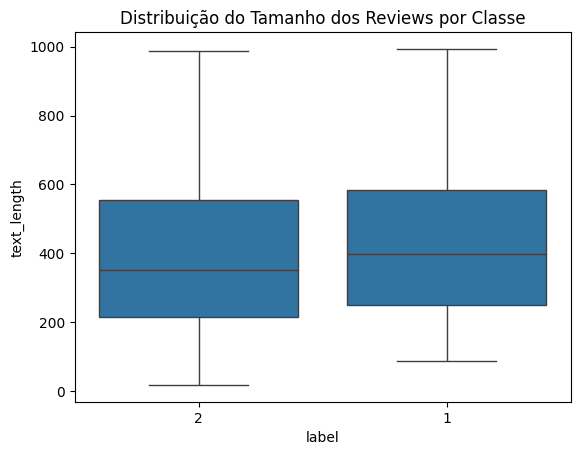

In [9]:
df_clean["text_length"] = df_clean["clean_text"].apply(len)

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="label", y="text_length", data=df_clean)
plt.title("Distribuição do Tamanho dos Reviews por Classe")
plt.show()


In [10]:
from collections import Counter

all_words = " ".join(df_clean["clean_text"])
word_freq = Counter(all_words.split())

print("Top 20 palavras mais comuns:")
word_freq.most_common(20)


Top 20 palavras mais comuns:


[('the', 8135),
 ('i', 4947),
 ('and', 4360),
 ('a', 4075),
 ('it', 3909),
 ('to', 3900),
 ('of', 3145),
 ('this', 3047),
 ('is', 2836),
 ('in', 1912),
 ('for', 1756),
 ('that', 1681),
 ('was', 1461),
 ('not', 1398),
 ('book', 1359),
 ('you', 1296),
 ('but', 1195),
 ('my', 1176),
 ('with', 1123),
 ('s', 1122)]

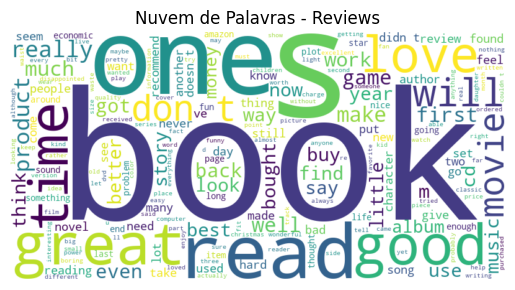

In [11]:
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color="white").generate(all_words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - Reviews")
plt.show()


Acurácia: 0.8325

Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.88      0.84       207
           2       0.86      0.78      0.82       193

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



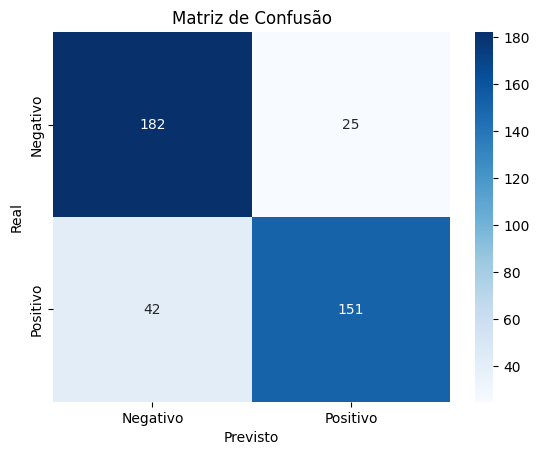

In [12]:
# ===== Baseline end-to-end: cria df_clean se faltar e treina TF-IDF + LogReg =====
import sys, os, re, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# garantir acesso aos módulos do projeto
sys.path.append(os.path.abspath(".."))

# -------- funções de leitura/limpeza (usa do projeto se disponível; senão, fallback) --------
try:
    from core.data.readcsv import load_fasttext
except:
    def load_fasttext(path, nrows=None):
        data = []
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            for i, line in enumerate(f):
                if nrows is not None and i >= nrows: break
                parts = line.strip().split(" ", 1)
                if len(parts) == 2:
                    label = parts[0].replace("__label__", "")
                    text = parts[1]
                    data.append((label, text))
        return pd.DataFrame(data, columns=["label", "text"])

try:
    from core.features.preprocess import transform_dataframe
except:
    def _clean_text_nb(t):
        if not isinstance(t, str): return ""
        t = t.lower()
        t = re.sub(r"[^a-z0-9\s]", " ", t)
        t = re.sub(r"\s+", " ", t).strip()
        return t
    def transform_dataframe(df):
        out = df.copy()
        out["clean_text"] = out["text"].apply(_clean_text_nb)
        return out

# -------- montar df_clean caso não exista no kernel --------
try:
    df_clean
except NameError:
    df = load_fasttext("../data/train.ft.txt", nrows=2000)
    df_clean = transform_dataframe(df)

# -------- treino / avaliação --------
X = df_clean["clean_text"]
y = df_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negativo","Positivo"],
            yticklabels=["Negativo","Positivo"])
plt.xlabel("Previsto"); plt.ylabel("Real"); plt.title("Matriz de Confusão"); plt.show()


In [13]:
import pickle

# salva tanto o modelo quanto o vectorizer em arquivos .pkl
with open("modelo_treinado.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Modelo e vectorizer foram salvos com sucesso!")


✅ Modelo e vectorizer foram salvos com sucesso!


In [14]:
import pickle

# carrega o modelo e o vectorizer
with open("modelo_treinado.pkl", "rb") as f:
    modelo_carregado = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer_carregado = pickle.load(f)

# faz um teste com uma frase nova
exemplo = ["O produto é muito bom, adorei a qualidade!"]
X_exemplo = vectorizer_carregado.transform(exemplo)
pred = modelo_carregado.predict(X_exemplo)

print("Frase de teste:", exemplo[0])
print("Classe prevista:", pred[0])  # deve sair 1 ou 2, dependendo de como estão os labels


Frase de teste: O produto é muito bom, adorei a qualidade!
Classe prevista: 2


In [15]:
with open("modelo_treinado.pkl", "rb") as f:
    model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)


In [16]:
import pickle

# Caminho direto (estamos já dentro de notebooks/)
path_model = "modelo_treinado.pkl"
path_vectorizer = "vectorizer.pkl"

# Carregar modelo e vetor
with open(path_model, "rb") as f:
    model = pickle.load(f)

with open(path_vectorizer, "rb") as f:
    vectorizer = pickle.load(f)

# Testar algumas frases
testes = ["O produto veio com defeito", "Excelente qualidade, recomendo!"]

X = vectorizer.transform(testes)
preds = model.predict(X)

for frase, p in zip(testes, preds):
    label = "Positivo" if p == 1 else "Negativo"
    print(f"Frase: {frase} -> {label}")


Frase: O produto veio com defeito -> Negativo
Frase: Excelente qualidade, recomendo! -> Negativo


In [17]:
import pandas as pd

# Carregar o dataset (ajustando o caminho porque o notebook está dentro de /notebooks)
df = pd.read_csv("../data/train.ft.txt", sep="\t", header=None, names=["label", "text"])

# Mostrar a contagem de cada classe
print(df["label"].value_counts())


label
__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1
_